## Background
We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification, and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal, we are working on designing an ever-evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Data

The data comes from the direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case, a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### Features:

    • age: age of customer (numeric)
    • job: type of job (categorical)
    • marital: marital status (categorical)
    • education: (categorical)
    • default: has credit in default? (binary)
    • balance: average yearly balance, in euros (numeric)
    • housing: has a housing loan? (binary)
    • loan: has a personal loan? (binary)
    • contact: contact communication type (categorical)
    • day: last contact day of the month (numeric)
    • month: last contact month of the year (categorical)
    • duration: last contact duration, in seconds (numeric)
    • campaign: number of contacts performed during this campaign and for this client (numeric, includes the last contact)
    
### Target:

    • y - has the client subscribed to a term deposit? (binary)

## Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

### Success Metric(s):
**Hit %81** or above accuracy by evaluating with **5-fold** cross-validation and reporting the average performance score.

### Bonus(es):
- We are also interested in finding customers who are **more likely** to buy the investment product. Determine the **segment(s)** of customers our client should prioritize.
- What makes the customers buy? Tell us **which feature** we should be focusing more on.

## 0. Import the necessary libraries

In [1]:
# To ignore warnings
import warnings

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Algorithms to use
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn import tree

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Set a seed value
seed_value= 42

# # Report it that number to your experiment tracking system.
# experiment = Experiment(project_name=”Classification model”)
# experiment.log_other(“random seed”, seed_value)

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# # 5. For layers that introduce randomness like dropout, make sure to set seed values 
# model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


In [3]:
# loading in datasets
df = pd.read_csv('term-deposit-marketing-2020.csv')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [6]:
# Checking summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


## **1. Initial Observations:**
- There are **40,000** observations and **13** columns.
- There are **no null values** in the data.
- There are **5 numerical** columns and the rest are **categorical**.
- The output **y** column is a categorical column containing yes or no indicating whether or not the customer has subscribed to a term loan.  We will use this column as our **label**. 

### Let's explore all the numerical columns

#### **A. Exploring the Data Distribution**

In [7]:
# Creating a list of numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

age
Skew : 0.44


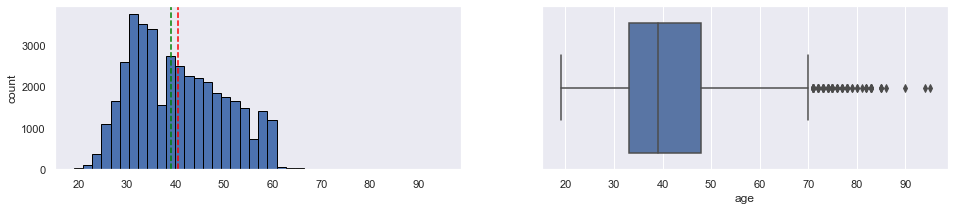

balance
Skew : 8.26


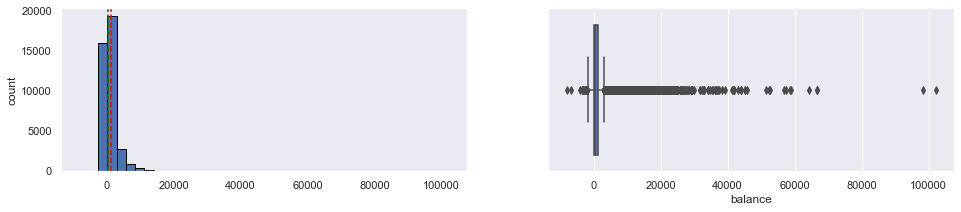

day
Skew : 0.07


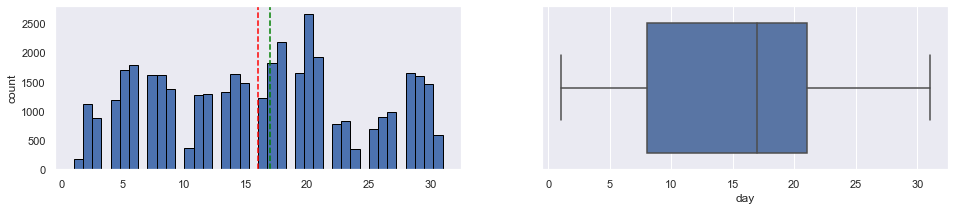

duration
Skew : 3.17


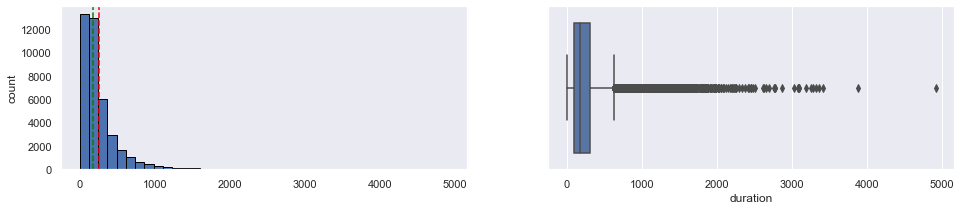

campaign
Skew : 4.73


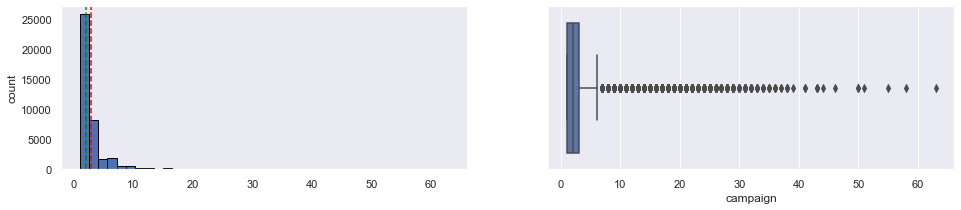

In [8]:
# Plotting a histogram and boxplot to check the distribution of our numerical data
sns.set(font_scale = 1)
cont_cols = list(df[num_cols])
for col in cont_cols:
    print(col)
    print('Skew :',round(df[col].skew(),2))
    plt.figure(figsize=(16,3))
    plt.subplot(1,2,1)
    df[col].hist(bins=40, grid=False, ec='black')
    plt.axvline(x = df[col].mean(), linestyle ="--", color ='red')
    plt.axvline(x = df[col].median(), linestyle ="--", color ='green')
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.show()

**Key Observations:**
- The current **average age** of our clients are **around 40**.  There are a little bit of an outlier for clients over 70.
- Average balance tend to be on the low side at around 1,300 dollars but we have clients potential balances up to 100,000 dollars.  One question is **how can we increase** this average?
- We have a **huge skew** in call **duration** - average calls are **around 250** seconds, outliers start at around 750 seconds.  The question is **what percentage of conversions happen above 750** calls?  
- **Similarly**, there is a huge **skew in campaign** contacts, **averaging 3 contacts** per customers with outliers start around 7 contacts.  Again, we should look at **percentage of conversations above 7** contacts. 

#### **B. Exploring the Conversion Rates across Different Catagories**

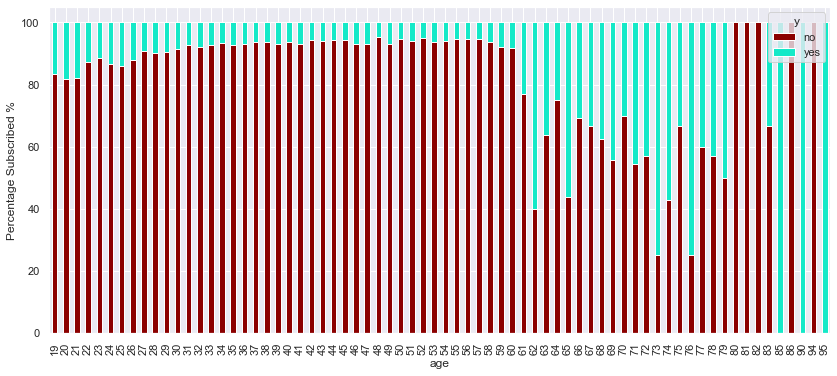

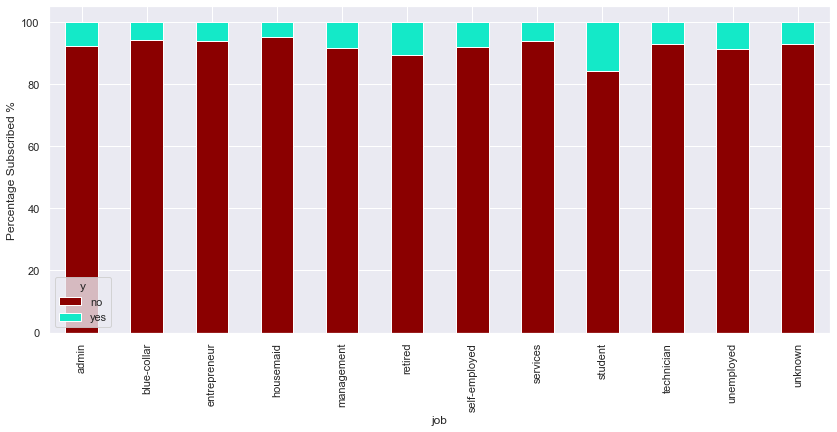

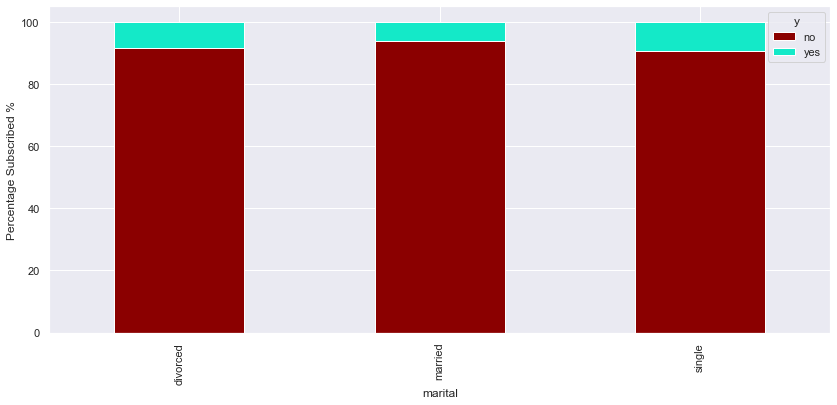

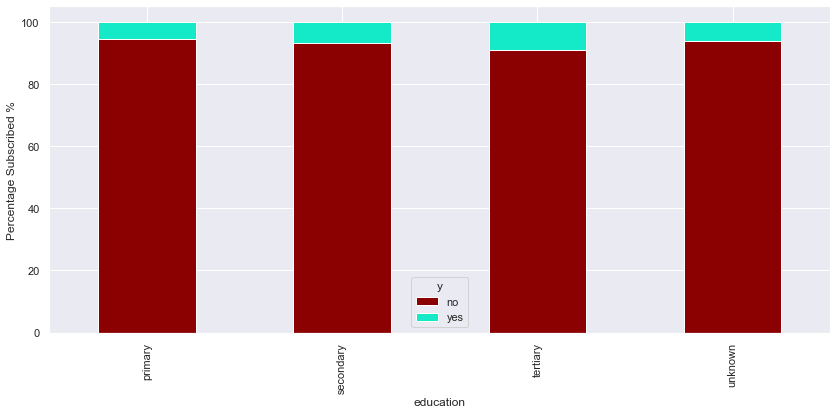

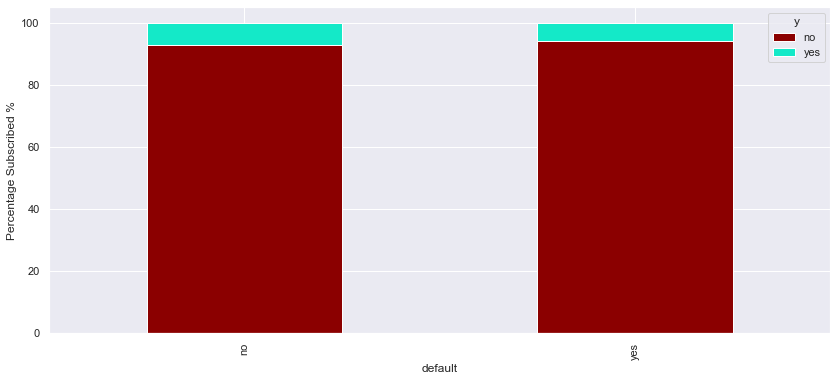

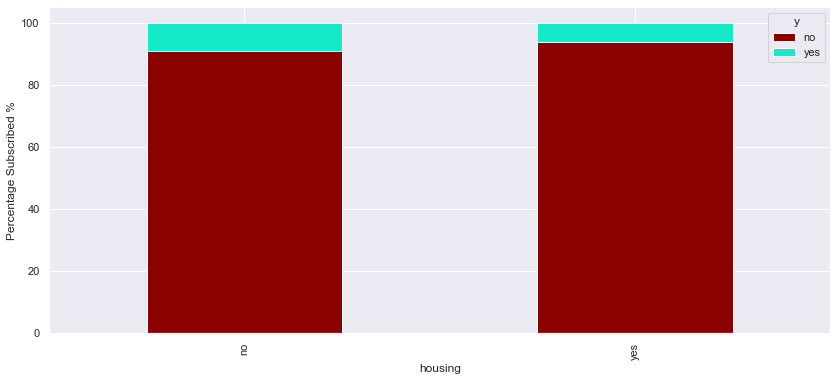

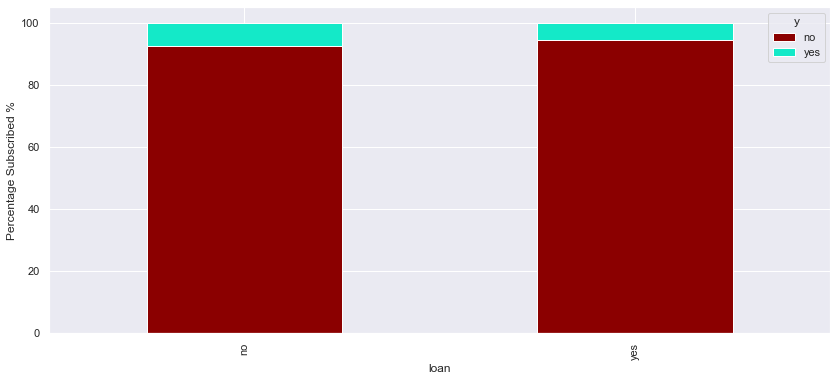

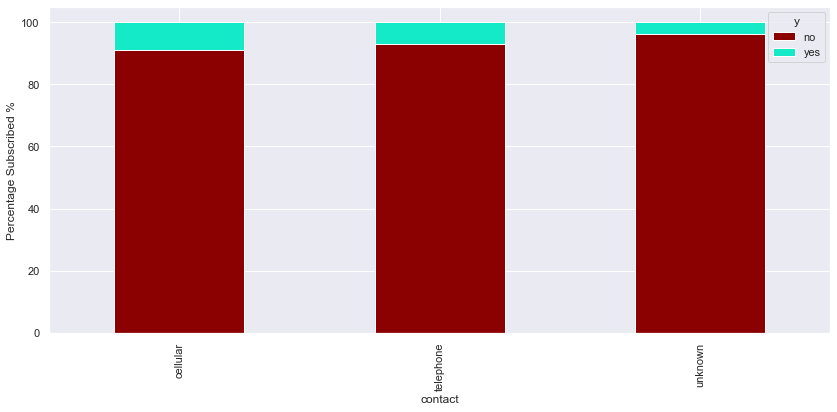

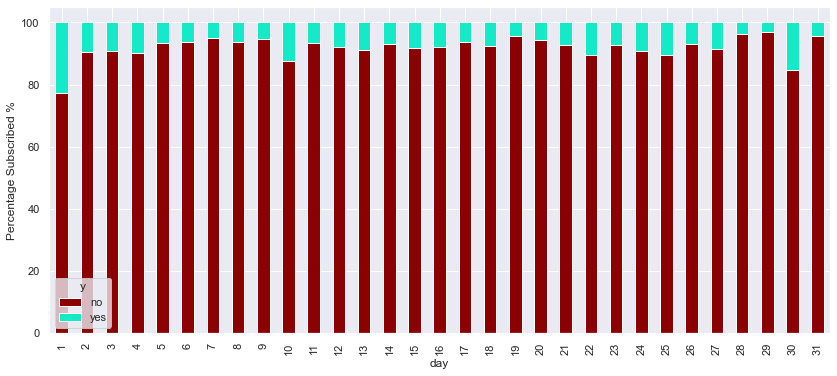

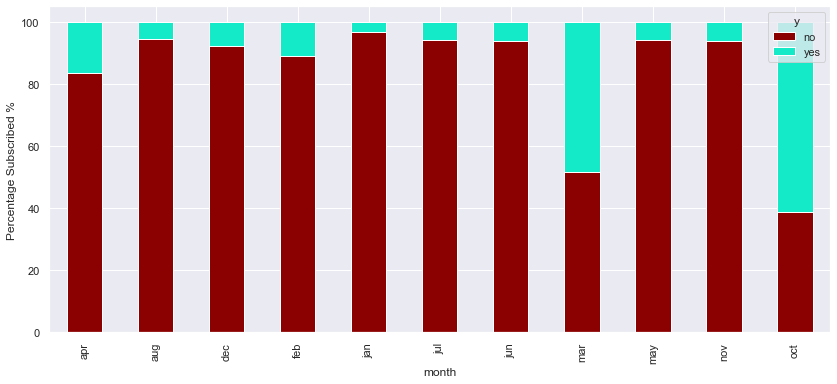

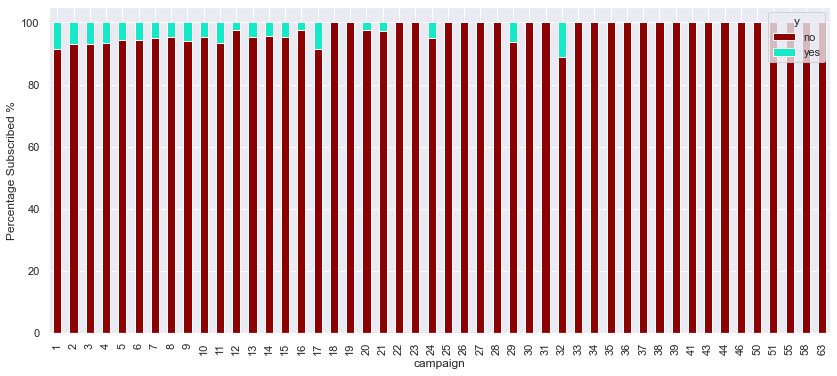

In [9]:
cols = df.columns
colors = ['#8B0000', '#14e9c8']
for i in cols:
    if i not in ['y', 'balance', 'duration']:
        (pd.crosstab(df[i], df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                                color = colors)
        plt.ylabel('Percentage Subscribed %')
        

**Observations:**
- We see conversion rate start to climb **over the age of 60** have a higher rate of apply for term loan.  
- There are higher conversion rates among those who **don't own homes** and who **don't have loans** - possibly because that thye have more available money or more incentive to commit to term deposits.
- **Students and Retirees** seem to have higher rates of conversion.  
- Interestingly, customers whose last month contacted in **March** or **October** have higher conversion rates. **Again**, these may again be explained as above that lower volumn skews that percentage higher or it could indicate an area to study to see if this group yields higher applicant rates.
- In terms of **how many contacts** during a campaign it seems that it's **no longer effective** after **30** contacts. The conversion rates begins to diminish after the 1st call and becomes almost non-existent after the 20th call except for some anomolies. The **recommendation is to stop** when the contact number reaches **20**.  

In [10]:
all_subsribers = df['y'].value_counts()[1]

In [11]:
df_hdur_1 = df[df['duration'] > 1500]
subscriber_hdur_1 = df_hdur_1['y'].value_counts()[1]

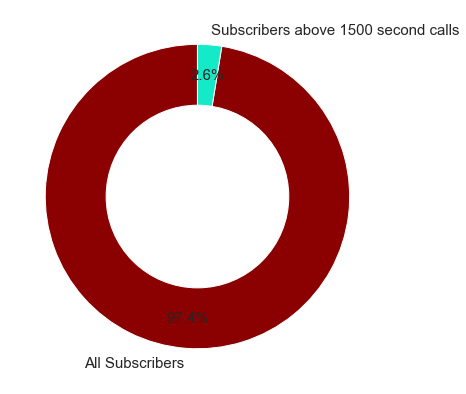

In [12]:
# Graphing our labelled categories
category_names = ['All Subscribers', 'Subscribers above 1500 second calls']
sizes = [all_subsribers, subscriber_hdur_1]

plt.figure(figsize = (7, 7))
plt.pie(sizes, labels = category_names, textprops = {'fontsize': 15}, startangle=90, 
        autopct='%1.1f%%', colors = colors, pctdistance=0.8)

center_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

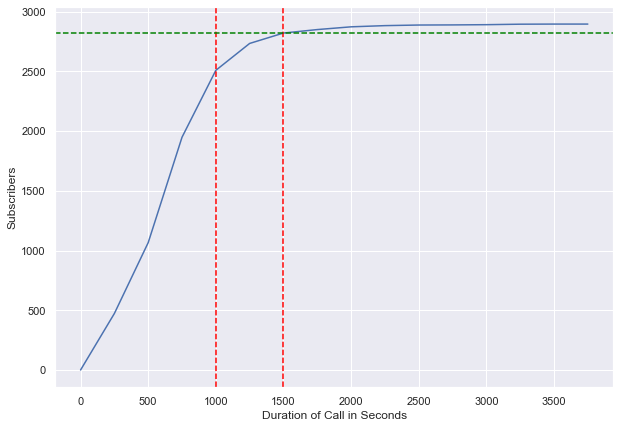

In [13]:
total_subscribers = df['y'].value_counts()[1].max()
duration = []
subscribers = []
sub_remainder = []

for i in range(0, 4000, 250):
    
    dur = df[df['duration'] > i]
#     if dur['y'].value_counts()[1] >= 1:
    subs_dur = total_subscribers - dur['y'].value_counts()[1]
    subs_rem = dur['y'].value_counts()[1]
    duration.append(i)
    subscribers.append(subs_dur)
    sub_remainder.append(subs_rem)

#     print(subscribers, duration)
  
plt.figure(figsize=(10,7))
plt.plot(duration, subscribers)
plt.xlabel('Duration of Call in Seconds')
plt.ylabel('Subscribers')
plt.axvline(x = 1000, linestyle ="--", color ='red')
plt.axvline(x = 1500, linestyle ="--", color ='red')

dur = df[df['duration'] > 1500]
plt.axhline(y = total_subscribers - dur['y'].value_counts()[1], linestyle ="--", color ='green')
plt.show()
    

In [14]:
call_duration = pd.DataFrame(zip(duration, sub_remainder), columns=['call duration', 'subscribers remaining'])
call_duration

,call duration,subscribers remaining
0,0,2896
1,250,2423
2,500,1830
3,750,948
4,1000,388
5,1250,163
6,1500,76
7,1750,47
8,2000,24
9,2250,14


<AxesSubplot:xlabel='month'>

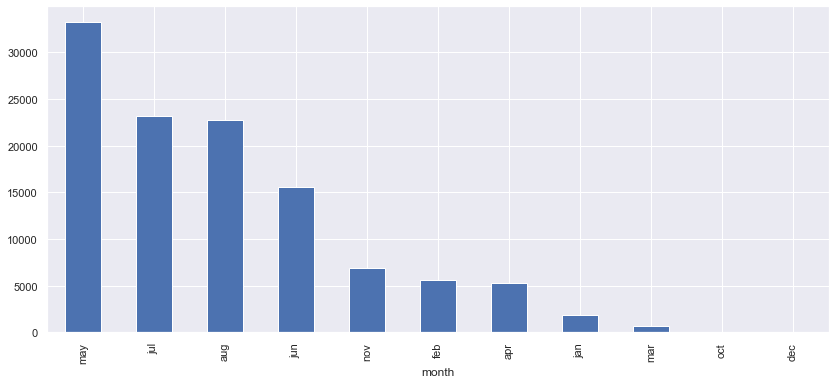

In [15]:
# Checking the total compaigns per month
df.groupby('month')['campaign'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='month'>

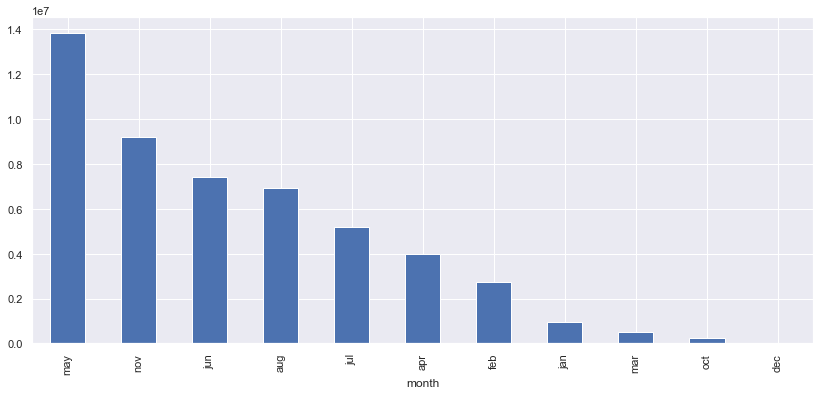

In [16]:
# Checking the balance total per month last contact
df.groupby('month')['balance'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='month'>

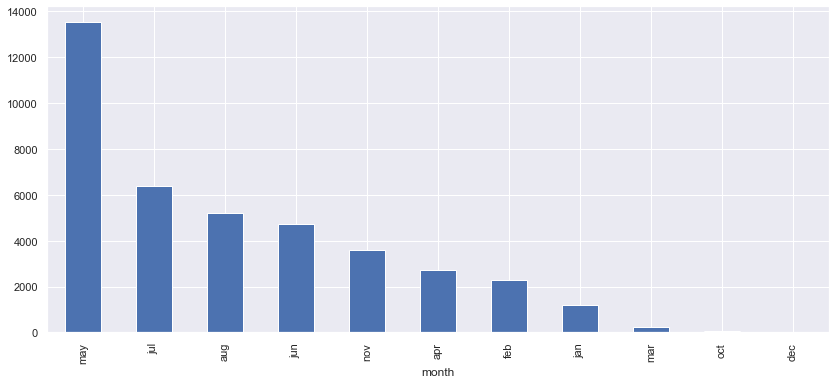

In [17]:
# Checking the balance total per month last contact
df.groupby('month')['balance'].count().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='month'>

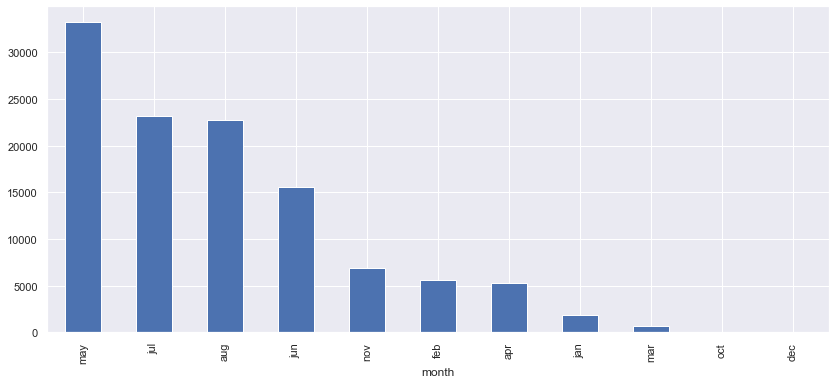

In [18]:
# Checking the total compaigns per month
df.groupby('month')['campaign'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

In [19]:
# Checking the total compaigns per month
df.groupby('month')['campaign'].count().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='month'>

Error in callback <function flush_figures at 0x0000024B152B2CA0> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:xlabel='month'>

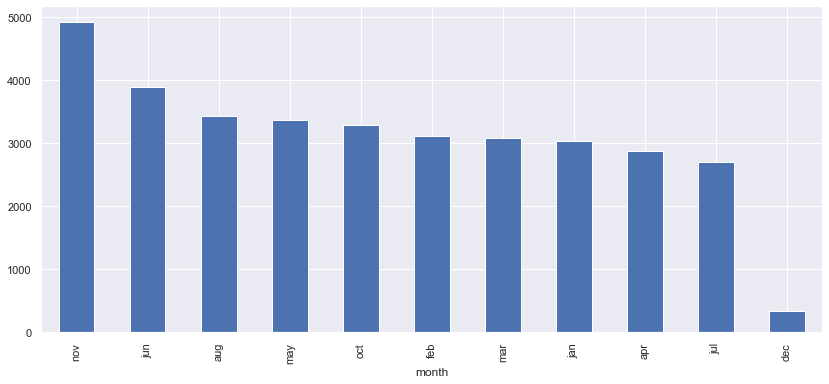

In [20]:
df.groupby('month')['duration'].max().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='month'>

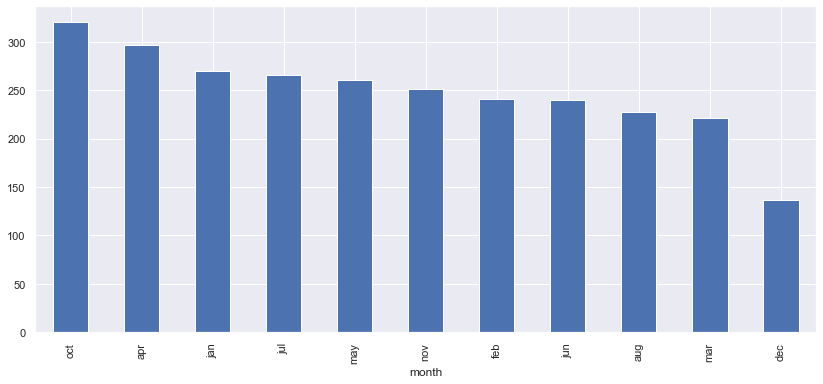

In [21]:
df.groupby('month')['duration'].mean().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='day'>

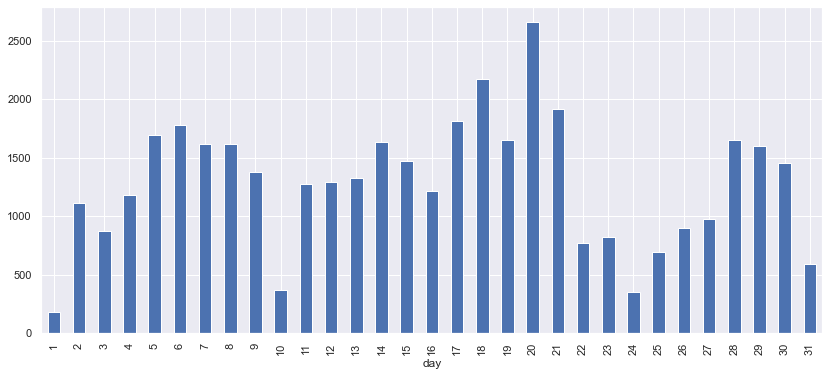

In [22]:
df.groupby('day')['campaign'].count().plot(kind='bar',figsize=(14,6))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [24]:
df_num = df

In [25]:
#mapping overtime and attrition
dict_education = {'tertiary': 3, 'secondary':2, 'primary':1, 'unknown':0}
dict_default = {'yes': 1, 'no':0}
dict_housing = {'yes': 1, 'no':0}
dict_loan = {'yes': 1, 'no':0}
dict_target = {'yes': 1, 'no': 0}


df_num['education'] = df_num.education.map(dict_education)
df_num['default'] = df_num.default.map(dict_default)
df_num['housing'] = df_num.housing.map(dict_housing)
df_num['loan'] = df_num.loan.map(dict_loan)
df_num['y'] = df_num.y.map(dict_target)

In [26]:
# Let's create a column that combines our age groups into decades 
bins = [19, 20, 30, 40, 50, 60, 70, 80, 90]
age_range = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']

d = dict(enumerate(age_range, 1))

df['AgeRange'] = np.vectorize(d.get)(np.digitize(df['age'], bins))

In [27]:
# Let's create a column that combines balances 
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
balance_range = ['<10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100+']

d = dict(enumerate(balance_range, 1))

df_num['balance_range'] = np.vectorize(d.get)(np.digitize(df_num['balance'], bins))

In [28]:
# Let's create a column that combines call durations
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
duration_range = ['<.5k', '.5-1k', '1-1.5k', '1.5-2k', '2-2.5k', '2.5-3k', '3-3.5k', '3.5-4k', '4-4.5k', '4.5-5k', '5k+']

d = dict(enumerate(duration_range, 1))

df_num['duration_range'] = np.vectorize(d.get)(np.digitize(df_num['duration'], bins))

In [29]:
df_num.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,AgeRange,balance_range,duration_range
0,58,management,married,3,0,2143,1,0,unknown,5,may,261,1,0,50-60,<10k,<.5k
1,44,technician,single,2,0,29,1,0,unknown,5,may,151,1,0,40-50,<10k,<.5k
2,33,entrepreneur,married,2,0,2,1,1,unknown,5,may,76,1,0,30-40,<10k,<.5k
3,47,blue-collar,married,0,0,1506,1,0,unknown,5,may,92,1,0,40-50,<10k,<.5k
4,33,unknown,single,0,0,1,0,0,unknown,5,may,198,1,0,30-40,<10k,<.5k
5,35,management,married,3,0,231,1,0,unknown,5,may,139,1,0,30-40,<10k,<.5k
6,28,management,single,3,0,447,1,1,unknown,5,may,217,1,0,20-30,<10k,<.5k
7,42,entrepreneur,divorced,3,1,2,1,0,unknown,5,may,380,1,0,40-50,<10k,<.5k
8,58,retired,married,1,0,121,1,0,unknown,5,may,50,1,0,50-60,<10k,<.5k
9,43,technician,single,2,0,593,1,0,unknown,5,may,55,1,0,40-50,<10k,<.5k


<AxesSubplot:xlabel='AgeRange'>

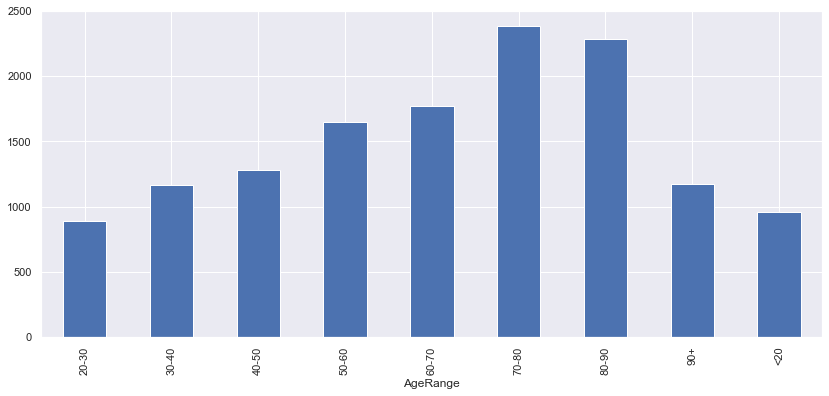

In [30]:
df_num.groupby('AgeRange')['balance'].mean().plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='AgeRange'>

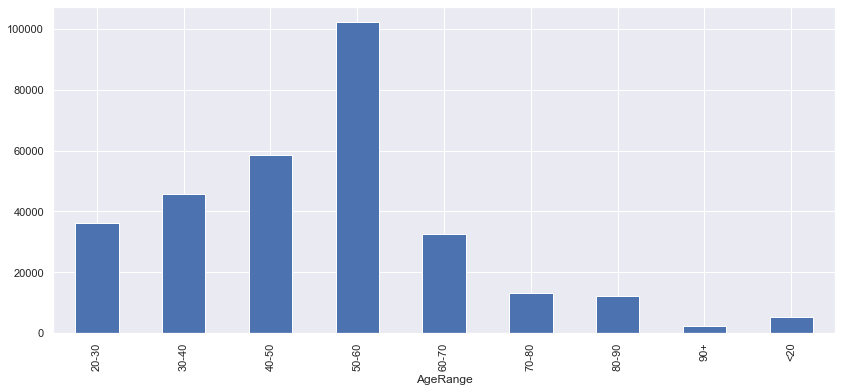

In [31]:
df_num.groupby('AgeRange')['balance'].max().plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='AgeRange'>

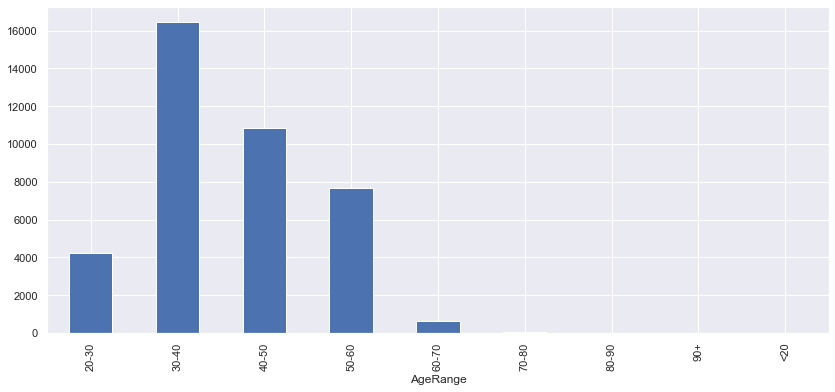

In [32]:
df_num.groupby('AgeRange')['balance'].count().plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='day'>

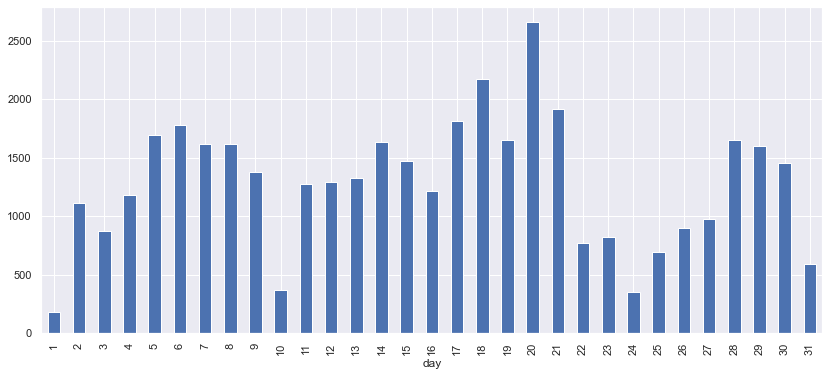

In [33]:
df_num.groupby('day')['campaign'].count().plot(kind='bar',figsize=(14,6))

Text(0, 0.5, 'Percentage Subscribed %')

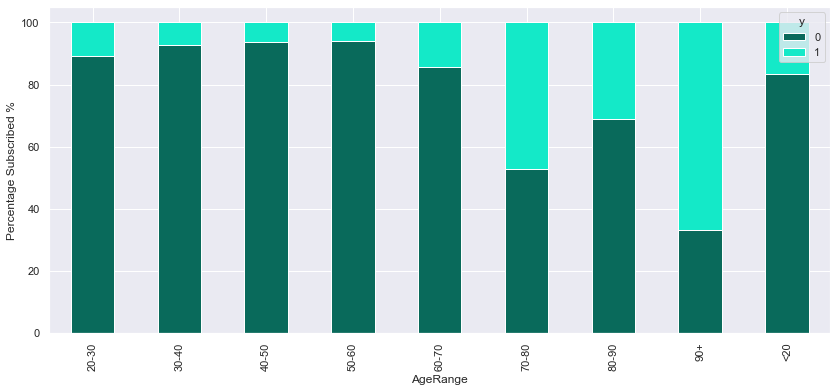

In [34]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df['AgeRange'],df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

Text(0, 0.5, 'Percentage Subscribed %')

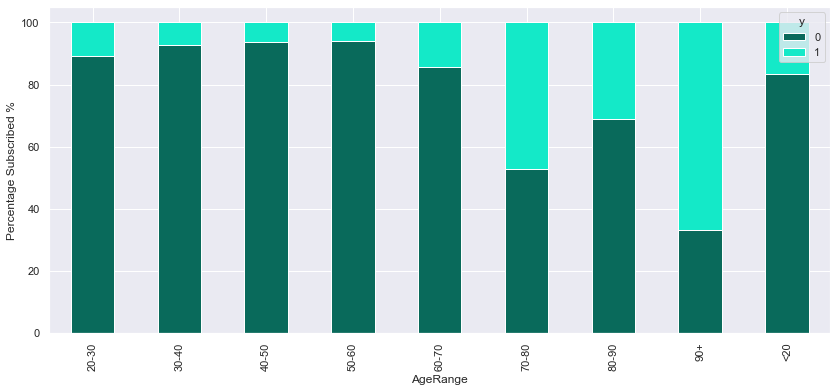

In [35]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df['AgeRange'],df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

Text(0, 0.5, 'Percentage Subscribed %')

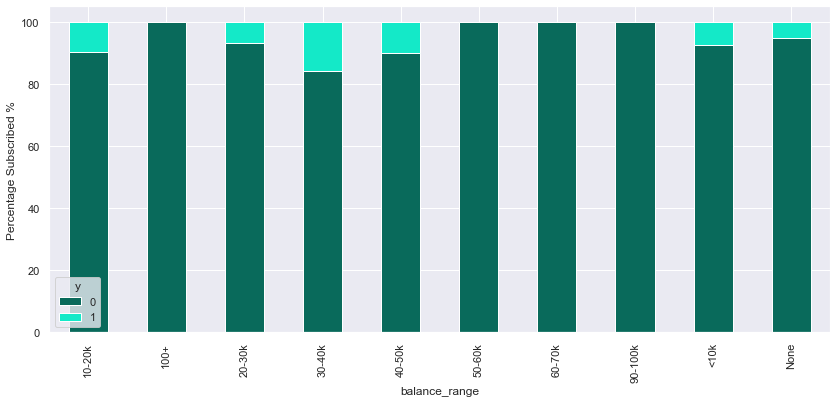

In [36]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df_num['balance_range'],df_num['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

Text(0, 0.5, 'Percentage Subscribed %')

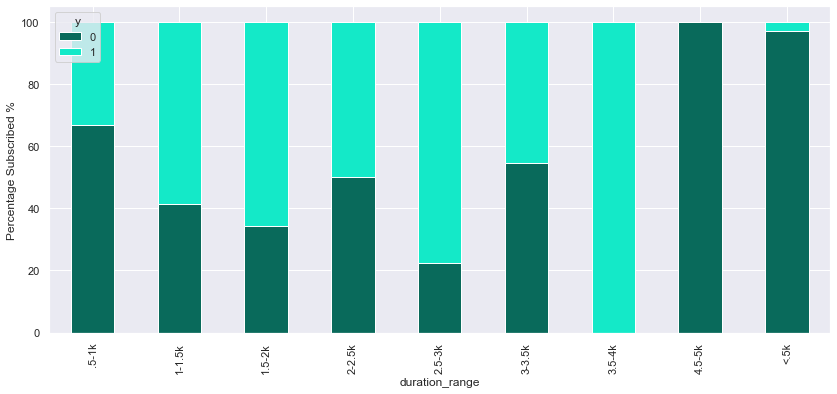

In [37]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df_num['duration_range'],df_num['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

In [38]:
df.nunique()

age                 70
job                 12
marital              3
education            4
default              2
balance           6849
housing              2
loan                 2
contact              3
day                 31
month               11
duration          1535
campaign            48
y                    2
AgeRange             9
balance_range       10
duration_range       9
dtype: int64

Text(0, 0.5, 'Percentage Subscribed %')

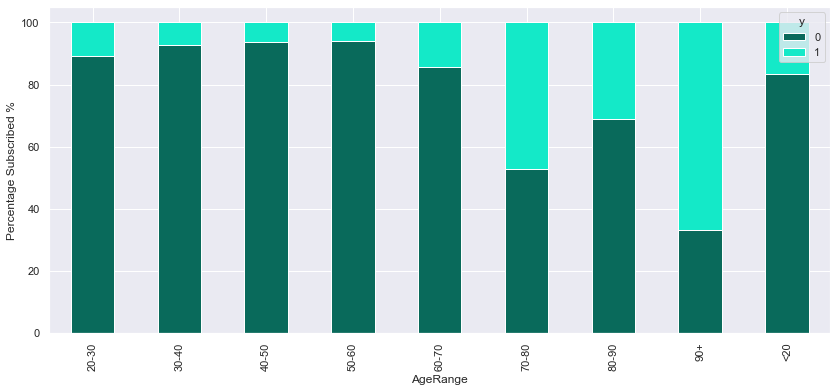

In [39]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df['AgeRange'],df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

Text(0, 0.5, 'Percentage Subscribed %')

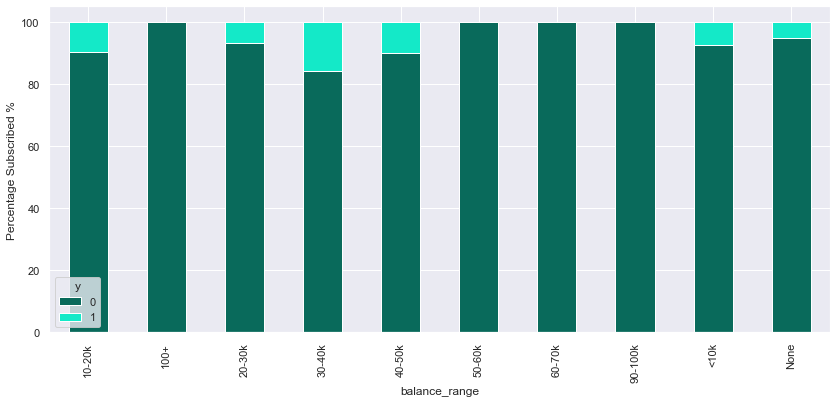

In [40]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df['balance_range'],df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

In [41]:
df_num.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,AgeRange,balance_range,duration_range
39995,53,technician,married,3,0,395,0,0,cellular,3,jun,107,1,0,50-60,<10k,<.5k
39996,30,management,single,3,0,3340,0,0,cellular,3,jun,238,3,1,30-40,<10k,<.5k
39997,54,admin,divorced,2,0,200,0,0,cellular,3,jun,170,1,1,50-60,<10k,<.5k
39998,34,management,married,3,0,1047,0,0,cellular,3,jun,342,1,0,30-40,<10k,<.5k
39999,38,technician,married,2,0,1442,1,0,cellular,3,jun,113,1,0,30-40,<10k,<.5k


In [42]:
# Counting the Total Number of Applicants per age group
df_num[df_num['y'] == 1].groupby(['AgeRange','y']).size().reset_index(name='count')

,AgeRange,y,count
0,20-30,1,463
1,30-40,1,1181
2,40-50,1,671
3,50-60,1,448
4,60-70,1,91
5,70-80,1,33
6,80-90,1,5
7,90+,1,2
8,<20,1,2


In [43]:
df.nunique()

age                 70
job                 12
marital              3
education            4
default              2
balance           6849
housing              2
loan                 2
contact              3
day                 31
month               11
duration          1535
campaign            48
y                    2
AgeRange             9
balance_range       10
duration_range       9
dtype: int64

KeyboardInterrupt: 

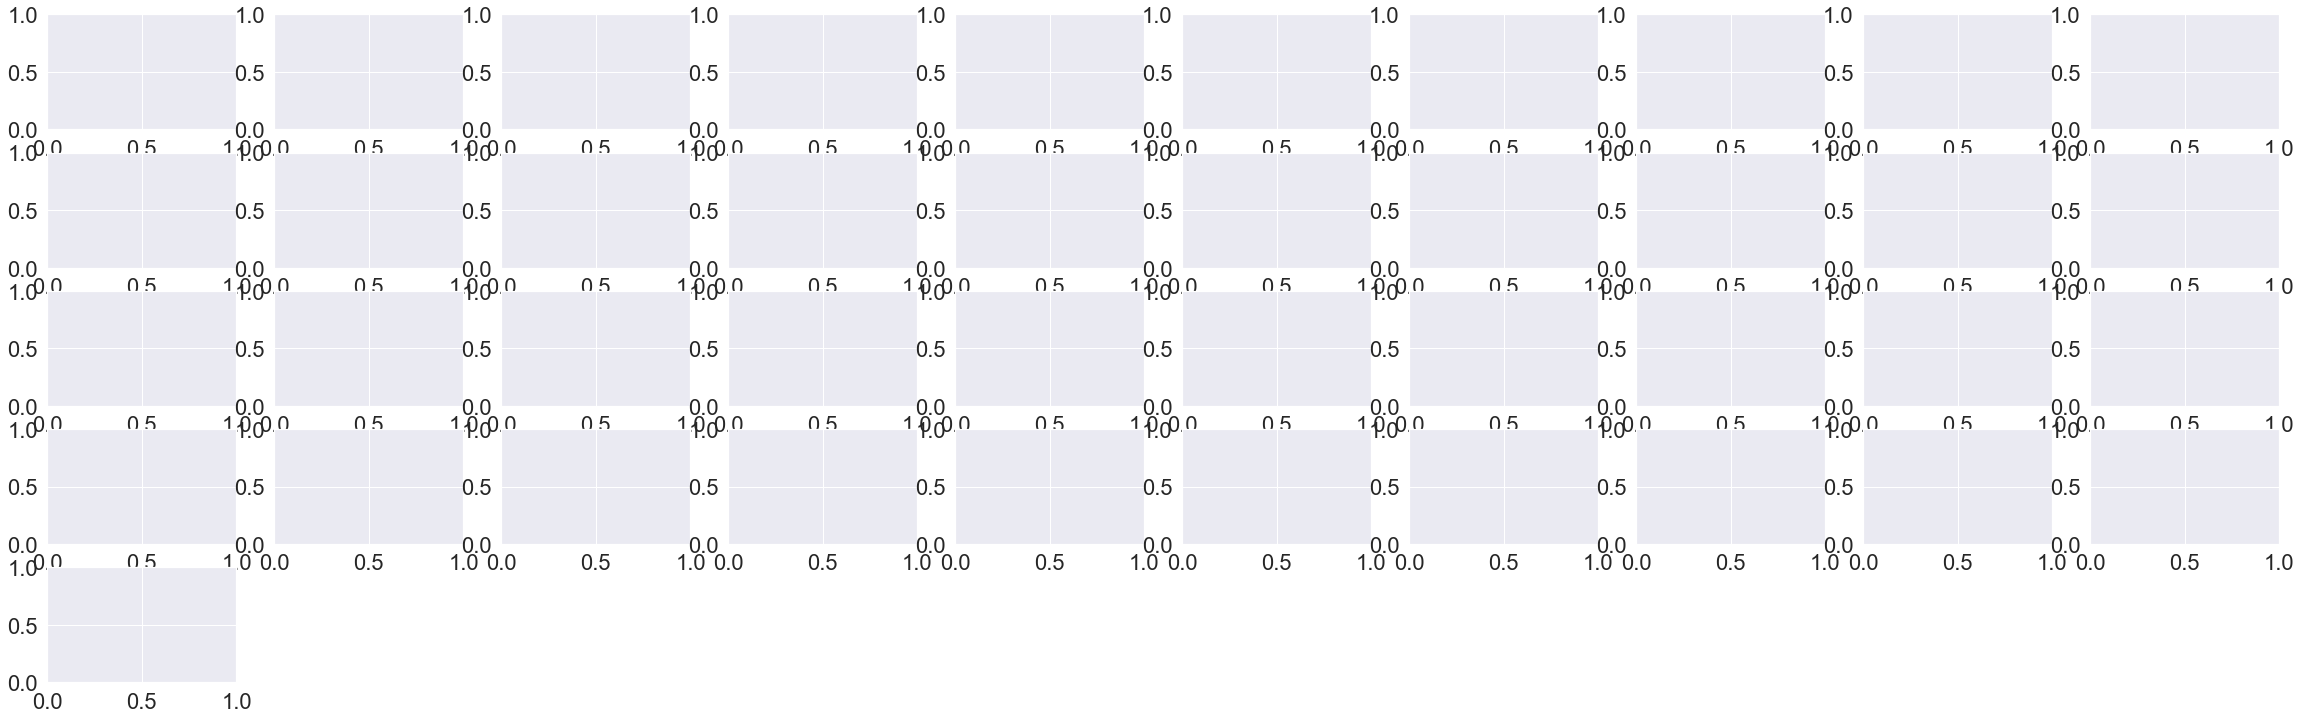

In [44]:
data = df_num
sns.set(font_scale = 2)
sns.pairplot(data, kind="reg", aspect=16/10, plot_kws={'line_kws':{'color':'red'}})
plt.show()

In [ ]:
# Creating a mask to mask off top half of correlation heatmap
mask = np.zeros_like(df_num.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

In [ ]:
# plotting the correation between numerical variables
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
sns.heatmap(df_num.corr(),annot=True, fmt='0.2f', cmap='YlGnBu', mask=mask)

### Let's Look Label Class Distribution

In [ ]:
# Getting a count of churn column
df_num['y'].value_counts()

In [ ]:
non_subscriber = df_num['y'].value_counts()[0]
subscriber = df_num['y'].value_counts()[1]

In [ ]:
# Graphing our labelled categories
category_names = ['Non-subscriber', 'Subscriber']
sizes = [non_subscriber, subscriber]
colors = ['#096a5b', '#10bfa4']

plt.figure(figsize = (7, 7))
plt.pie(sizes, labels = category_names, textprops = {'fontsize': 15}, startangle=90, 
        autopct='%1.1f%%', colors = colors, pctdistance=0.8)

center_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

**Observations:**
- We have an **highly imbalanced class** of applicant verse non-applicants, as typical in these studies.  We will need to adjust for this when we build our models later.
- Percentage wise it looks like people **over the age of 60** have a higher rate of apply for term loan.  But our distribution of customers show that we don't have as many customers over 60 - so even though it's a higher percentage, it only accounts of a smaller number of applicants in comparison.   
- It **may be** that if we add more customers above 60, it may bring in more applicants or it could mean that as we bring in more customers above 60, the application percentage will begin to match the other age groups.  This could be an area to research.
- There are higher percentage of applicants among those who **don't own homes** and who **don't have loans** - it's possible that these have more available money to save.
- **Students and Retirees** seem to have higher percentage rates of term loan applicants.  
- Also customers whose last month contacted in **March** or **October** have higher applicant rate. **Again**, these may again be explained as above that lower volumn skews that percentage higher or it could indicate an area to study to see if this group yields higher applicant rates.
- In terms of **how many contacts** during a campaign it seems that it's **no longer effective** after **30** contacts.  

## 2. Building our Models

In [ ]:
# We want to use lazypredict to test out a vast array of models to see which has the best performance
import lazypredict

In [ ]:
# Instantiating LazyClassifier (For Classification Problem.  LazyPredict also has the LazyRegressor for Regression Problems)
from lazypredict.Supervised import LazyClassifier

In [ ]:
#creating list of dummy columns
to_get_dummies_for = ['job', 'marital', 'contact', 'month']

#creating dummy variables
df_num = pd.get_dummies(data = df_num, columns= to_get_dummies_for, drop_first= True)  

In [ ]:
# Separating target variable and other variables
Y = df_num.y
X = df_num.drop(columns = ['y', 'AgeRange', 'balance_range', 'duration_range'])

In [ ]:
# Splitting the data
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.30, random_state=seed_value)

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)

print(models)

In [ ]:
#creating metric function 

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Subscribed', 'Subscribed'], 
                yticklabels=['Not Subscribed', 'Subscribed'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

**Model Performance**

Our **top 8 best** performing models are Perceptron, NearestCentroid, GaussianNB, BernoulliNB, LinearDiscriminantAnalysis, DecisionTreeClassifier, LGBMClassifier and XGBClassifier.  We will develope these models in depth.  

In [ ]:
# Put models in a dictionary
models = {"Perceptron": Perceptron(),
          "Nearest Centroid": NearestCentroid(), 
          "Passive Agressive": PassiveAggressiveClassifier(),
          "Lightgbm": lgb.LGBMClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "LDA": LinearDiscriminantAnalysis(),
          "XGBC": xgb.XGBClassifier(),
          "QDA": QuadraticDiscriminantAnalysis()}

# Create function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [ ]:
model_scores = fit_and_score(models=models,
                             x_train=x_train,
                             x_test=x_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

In [ ]:
# Getting a count of churn column
df_num['y'].value_counts()

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import PassiveAggressiveClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
# Building perceptron classifier
perc_clf = Perceptron()

In [ ]:
# fitting perceptron classifier
perc_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_perc = perc_clf.predict(x_train)
metrics_score(y_train, y_train_pred_perc)

In [ ]:
# checking performance on test dataset
y_test_pred_perc = perc_clf.predict(x_test)
metrics_score(y_test, y_test_pred_perc)

In [ ]:
# instantiating the nearest neighbor classifier
nc_clf = NearestCentroid(metric='euclidean')

In [ ]:
# fitting nearest centroid classifier
nc_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_nc = nc_clf.predict(x_train)
metrics_score(y_train, y_train_pred_nc)

In [ ]:
# checking performance on test dataset
y_test_pred_nc = nc_clf.predict(x_test)
metrics_score(y_test, y_test_pred_nc)

In [ ]:
# instantiating the passive agressive classifier
pa_clf = PassiveAggressiveClassifier()

In [ ]:
# fitting the passive agressive classifier
pa_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_pa = pa_clf.predict(x_train)
metrics_score(y_train, y_train_pred_pa)

In [ ]:
# checking performance on test dataset
y_test_pred_pa = pa_clf.predict(x_test)
metrics_score(y_test, y_test_pred_pa)

In [ ]:
# instantiating the lda classifier
lda_clf = LinearDiscriminantAnalysis()

In [ ]:
# fitting lda classifier
lda_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_lda = lda_clf.predict(x_train)
metrics_score(y_train, y_train_pred_lda)

In [ ]:
# instantiating the lda classifier
dt_clf = DecisionTreeClassifier()#(class_weight ={0: .928, 1: .072})

In [ ]:
# fitting decision tree
dt_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_dt = dt_clf.predict(x_train)
metrics_score(y_train, y_train_pred_dt)

In [ ]:
# checking performance on test dataset
y_test_pred_dt = dt_clf.predict(x_test)
metrics_score(y_test, y_test_pred_dt)

In [ ]:
# instantiating the lda classifier
lgb_clf = lgb.LGBMClassifier()

In [ ]:
# fitting lgb classifier
lgb_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_lgb = lgb_clf.predict(x_train)
metrics_score(y_train, y_train_pred_lgb)

In [ ]:
# instantiating the xgb classifier
xgb_clf = xgb.XGBClassifier()

In [ ]:
# fitting xgb classifier
xgb_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_xgb = xgb_clf.predict(x_train)
metrics_score(y_train, y_train_pred_xgb)

In [ ]:
# instantiating the qda classifier
qda_clf = QuadraticDiscriminantAnalysis()

In [ ]:
# fitting qda classifier
qda_clf.fit(x_train, y_train)

In [ ]:
# checking performance on train dataset
y_train_pred_qda = qda_clf.predict(x_train)
metrics_score(y_train, y_train_pred_qda)